<a href="https://colab.research.google.com/github/yesimcebeci/Twitter-Sentiment-Analysis-on-Airlines/blob/main/Preprocessing_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [75]:
# !pip install sklearn
# !pip install wordcloud
# !pip install bs4
# !pip install nltk
# !pip install gensim==4.2.0
# !pip install Keras-Preprocessing

In [76]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
# importing necessary libraries for EDA and Cleaning
import pandas as pd
# increasing column width by using pandas display option
# This way we can see all given text
pd.options.display.max_colwidth = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')

# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import emoji


# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , StratifiedKFold

# Machine Learning Models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB



from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional,Embedding
from keras.layers import Dropout, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model


# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
path = "/content/drive/MyDrive/Sentiment Analysis/Tweets.csv"
tweets_raw = pd.read_csv(path)

In [80]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The US Airline Sentiment dataset has so many features. Among them, in this project I will be working with the **'airline' ,  'text'  and  'airline_sentiment'** features. Here, I will consider **'airline_sentiment'** as our target label for the classifier

In [81]:
# Drop dublicates if there is any
tweets = tweets_raw.drop_duplicates(subset=["tweet_id"], keep=False) 
tweets.shape

(14330, 15)

In [82]:
# Dropping unnecessary columns
tweets = tweets[['airline','text','airline_sentiment']]
tweets.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,Virgin America,@VirginAmerica and it's a really big bad thing about it,negative


In [83]:
tweets.isna().sum()

airline              0
text                 0
airline_sentiment    0
dtype: int64

In [84]:
#Change Text to String
tweets["text"] = tweets["text"].astype(str)

#Remove neutral sentiment to focus on just the positive and negative sentiment
tweets = tweets[tweets["airline_sentiment"] != 'neutral']
tweets.index = np.arange(0, len(tweets))
tweets.shape

(11295, 3)

In [85]:
# in our case we are trying to find as possible as negative sentiment.I will assign negative sentiment as 1 , positive as 0
# replacing the categorical values of 'airline_sentiment' to numeric values as positive = 0 , negative = 1
tweets['airline_sentiment'].replace(('positive', 'negative'), (0, 1), inplace=True)
tweets['airline_sentiment'].value_counts()

1    8992
0    2303
Name: airline_sentiment, dtype: int64

## Text Preprocessing for Sentiment Analysis




Data cleaning was performed to improve the learning efficiency of machine learning models. Machine learning models show improved classification accuracy if the data are pre-processed.The pre-processing was done using the natural language toolkit.

In this part we will be:
- removing **tagged airlines** such as @united,
- converting text to **lowercase** (decreases the importance of more frequent terms in the text.)
- removing **numbers** (decreases the complexity of training the models)
- removing **punctuations** (it does not contribute to text analysis)
- removing **whitespace**,
- removing **emoji** (it does not contribute to text analysis)

In [86]:
tweets[['text']][1000:1020]


,text
1000,"@united just sent you a message on Facebook, how do I follow up a complaint re. Missing clothing out of checked baggage?"
1001,"@united why do I check in online if I still have to wait in line for an hour to ""check in"" at counter? #fuckinlame @naia_miaa"
1002,@united very poor customer service. I WILL think again befor Flight Booking Problems another United flight.
1003,@united an over booked flight to start with and a red eye from lax to bos with no reclining seat.... #lastflightwithyouever
1004,@united an efficient layout at kiosks/bag drop lines would help as there is no definition to space. Additional friendly and helpful staff
1005,"@united - 75% of a plane's passengers boarding in your ""Premier"" groups might be an indication of a broken process."
1006,@united EWR agent Barbara was FABULOUS and an example of CUST. SERV. A pleasure talking to you😊 http://t.co/KMQuLY9g5E
1007,"@united Cancelled Flightled a flight cause the crew needed sleep.But it's totally okay to wake me up at 3am just to let me know it's Cancelled Flightled, again."
1008,"@united changed my last name for my MileagePlus acct on the site in an hour. @BA_USA had me on hold for 20mins, then 5 days &amp; no change yet"
1009,"@united flight landed 13 hours ago, 2 more flights CMH-IAD last night and still no bag..could have driven it from CMH"


In [87]:
df = tweets.copy()

#Removing tagged airlines
df["text"] = df["text"].str.replace("(@+\w+)", "")

#Lowercasing text
df["text"] = df["text"].str.lower()

#Removing numbers
df["text"] = df["text"].str.replace('\d+', '', regex=True)

#Removing punctuations
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

df["text"] = df["text"].apply(lambda x: remove_punc(x))

#Removing Whitespace
df["text"] = df["text"].str.strip()

#Removing emoji
df["text"] = df["text"].apply(lambda x: emoji.demojize(x))


In [88]:
df[['text']][1000:1020]


,text
1000,just sent you a message on facebook how do i follow up a complaint re missing clothing out of checked baggage
1001,why do i check in online if i still have to wait in line for an hour to check in at counter fuckinlame
1002,very poor customer service i will think again befor flight booking problems another united flight
1003,an over booked flight to start with and a red eye from lax to bos with no reclining seat lastflightwithyouever
1004,an efficient layout at kiosksbag drop lines would help as there is no definition to space additional friendly and helpful staff
1005,of a planes passengers boarding in your premier groups might be an indication of a broken process
1006,ewr agent barbara was fabulous and an example of cust serv a pleasure talking to you httptcokmqulyge
1007,cancelled flightled a flight cause the crew needed sleepbut its totally okay to wake me up at am just to let me know its cancelled flightled again
1008,changed my last name for my mileageplus acct on the site in an hour had me on hold for mins then days amp no change yet
1009,flight landed hours ago more flights cmhiad last night and still no bagcould have driven it from cmh


Finally, we do all the basic text cleanings like removal of user name mentions,hashtags, numbers etc using the function below. Next step is  I will keep preprocessing and will create another function. This function will:
- remove **stopwords** , 
- **tokenize** text and 
- **lemmatize** each word

In [89]:
# Creating variable for english stopwords.
stop_words = stopwords.words('english')

In [90]:
def cleaning(data):
    
    #Tokenize
    text_tokens = word_tokenize(data.replace("'", "")) 
    
    #Removing Stopwords
    tokens_without_sw = [t for t in text_tokens if t not in stop_words]  
    
    #lemma
    text_lemma = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    cleaned_text = " ".join(text_lemma)

    return cleaned_text


In [91]:
#Applying function to target
df["text"] = df["text"].apply(cleaning)
df["text"].head()

0                                      plus youve added commercial experience tacky
1    really aggressive blast obnoxious entertainment guest face amp little recourse
2                                                              really big bad thing
3          seriously would pay flight seat didnt playing really bad thing flying va
4                                yes nearly every time fly vx ear worm wont go away
Name: text, dtype: object

- I preffered choose lemmatization instead of stemming, because the purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give meaningful representation such as “Chang”. Here, lemmatization comes into picture as it gives meaningful word.

- Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.

In [92]:
# Showing which words have the most counts in the all texts within each category.
FreqDist(" ".join(df["text"]).split()).most_common(50)

[('flight', 3684),
 ('get', 1122),
 ('hour', 1096),
 ('cancelled', 921),
 ('service', 910),
 ('thanks', 885),
 ('customer', 880),
 ('u', 877),
 ('time', 827),
 ('bag', 685),
 ('help', 682),
 ('plane', 646),
 ('im', 618),
 ('hold', 605),
 ('amp', 546),
 ('thank', 526),
 ('cant', 515),
 ('still', 513),
 ('call', 508),
 ('day', 500),
 ('delayed', 495),
 ('one', 489),
 ('airline', 488),
 ('gate', 481),
 ('need', 448),
 ('flightled', 438),
 ('back', 436),
 ('dont', 427),
 ('would', 419),
 ('delay', 411),
 ('phone', 406),
 ('hr', 402),
 ('got', 392),
 ('agent', 391),
 ('late', 390),
 ('seat', 389),
 ('please', 373),
 ('guy', 364),
 ('min', 349),
 ('like', 345),
 ('today', 344),
 ('waiting', 343),
 ('minute', 325),
 ('ive', 309),
 ('great', 308),
 ('make', 304),
 ('trying', 299),
 ('wait', 297),
 ('never', 296),
 ('fly', 295)]

In [93]:
# Showing which words have the most counts in the positive texts within each category.

all_positive_text = df.loc[df.airline_sentiment == 0].text.map(word_tokenize).values
all_positive_corpus = [word for text in all_positive_text for word in text]
freq =FreqDist(all_positive_corpus).most_common(50)


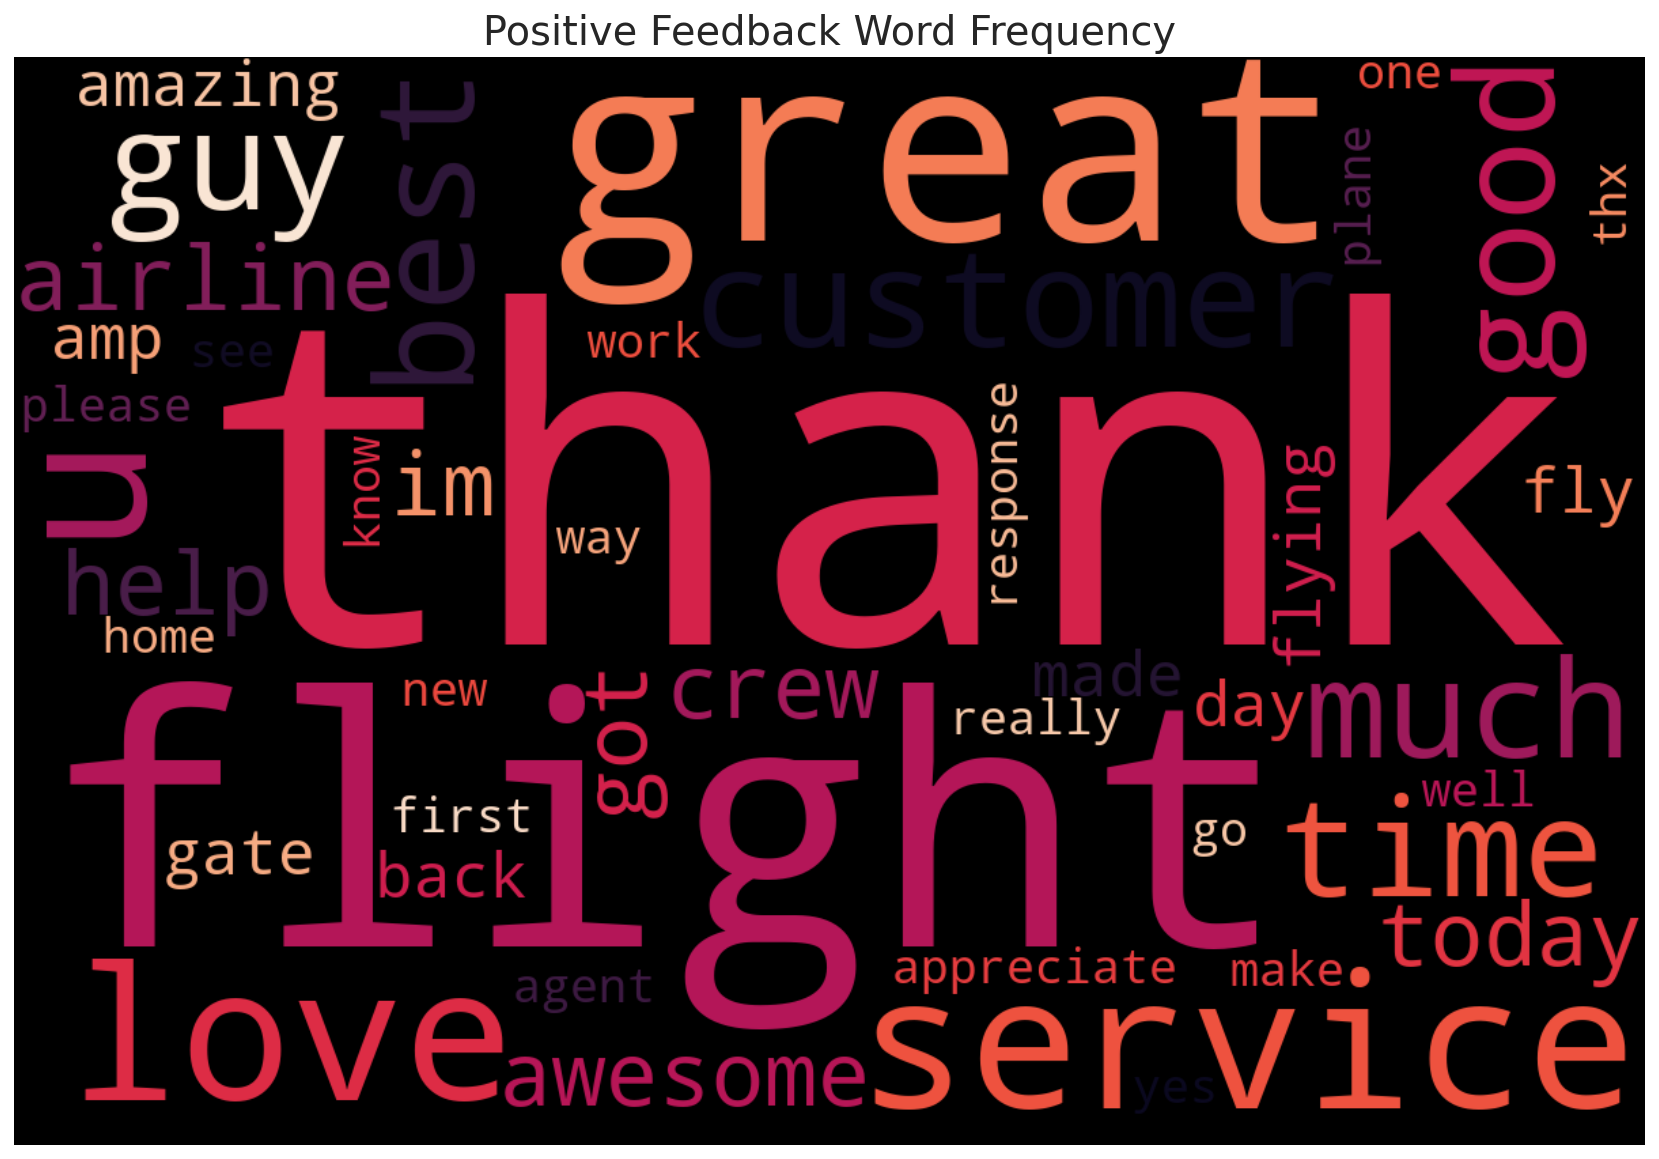

In [94]:
from wordcloud import WordCloud
all_positive_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800 , background_color='black', colormap='rocket').generate(all_positive_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- This bar chart shows us the top 50 most frequent words in positive feedback.The meaningful words that can be spotted in the positive sentiments’ word cloud directly include **“thank”**, **“flight”** and **“great”**. This shows people tend to appreciate the airline on social media when they have positive flight experience

In [95]:
# Showing which words have the most counts in the negative texts within each category.

all_negative_text = df.loc[df.airline_sentiment == 1].text.map(word_tokenize).values
all_negative_corpus = [word for text in all_negative_text for word in text]
freq = FreqDist(all_negative_corpus).most_common(50)


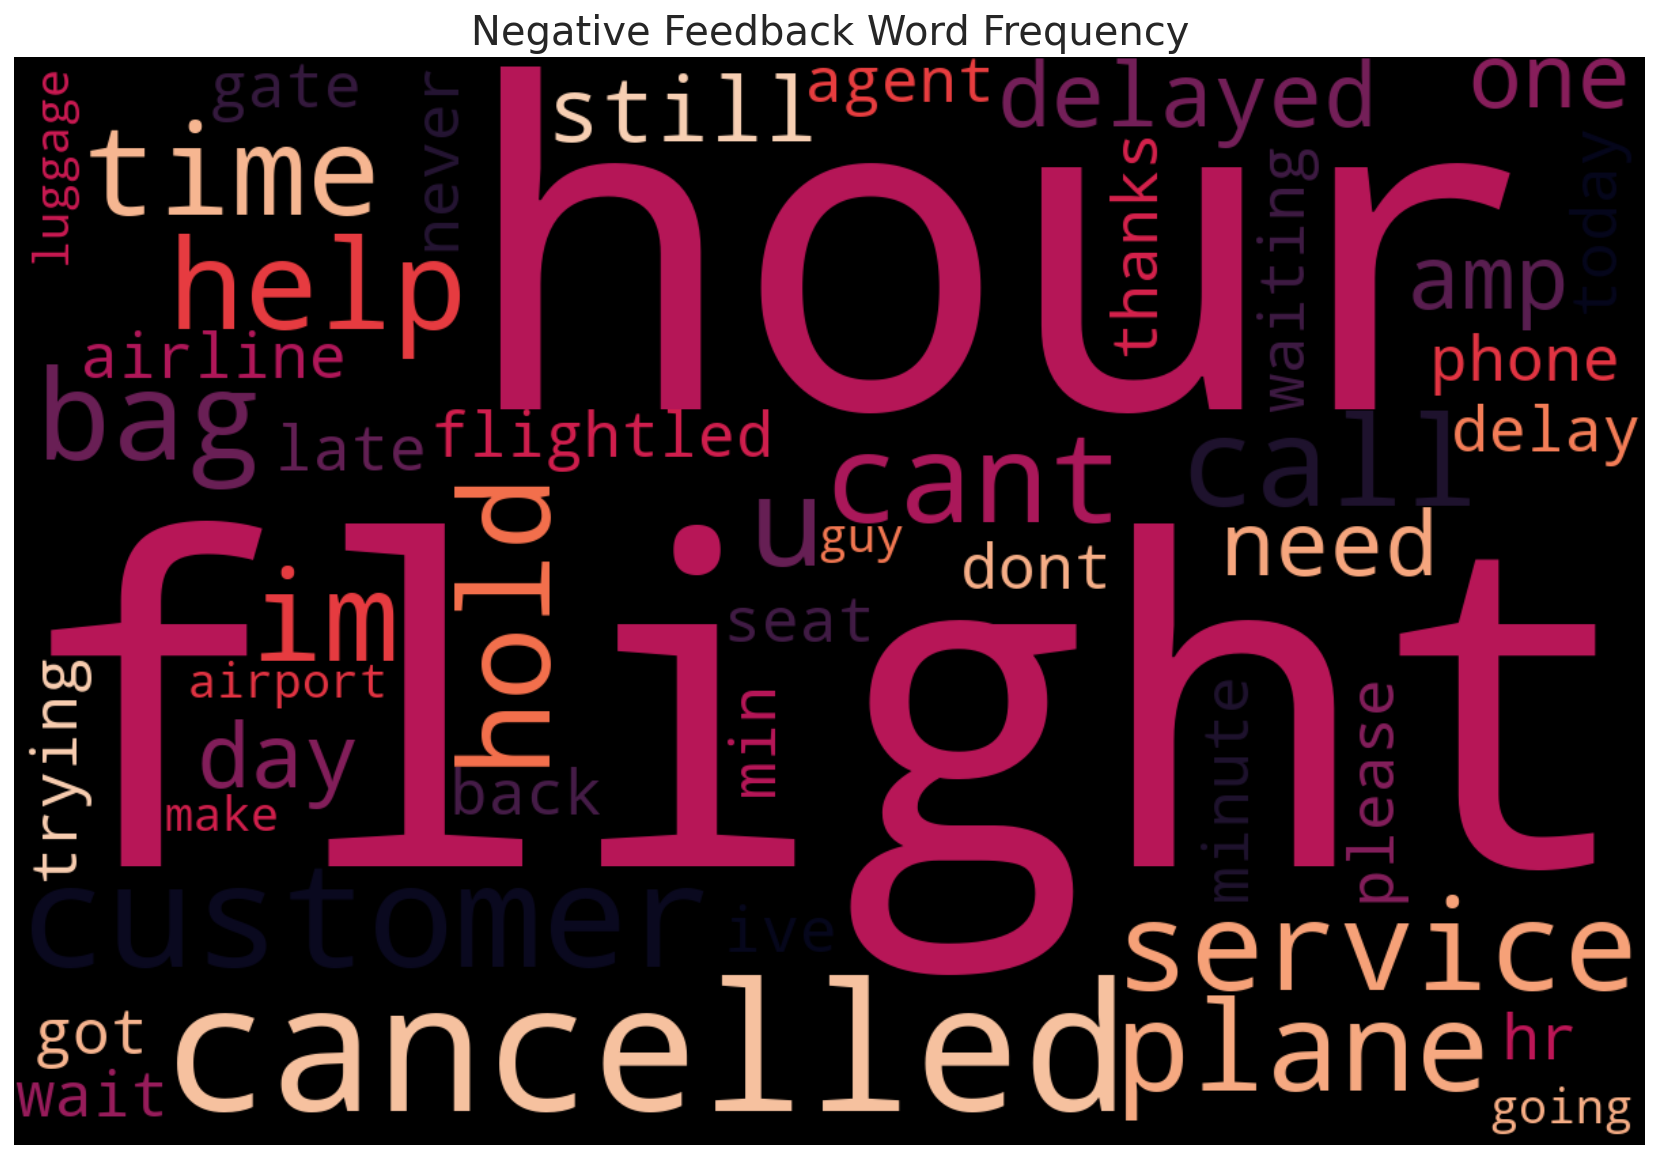

In [96]:
all_negative_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800, background_color='black', colormap='rocket').generate(all_negative_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- We observe from the word cloud that tweets related to **"flight"** and **"hour"** are causing the most negative tweets. And also  **"canceled"**,**"delayed"**, **"customer"** and **"service"** have higher frequencies than other words.
- Other complaints were related to **"layover"**, **"bag"**,**"hold"**  and  **"call"**  as seen in the word cloud.



# Model Preparation

# Vectorization

Now we can make use of **TfidfVectorizer** and **CountVectorizer**  to transfer Tweet contents into vectors, in order to train the model in the proper form and shape

So , What Is The Difference Between **TfidfVectorizer** and **CountVectorizer** ?

TF-IDF Vectorizer and Count Vectorizer are both methods used in natural language processing to vectorize text. However, there is a fundamental difference between the two methods.

- **CountVectorizer** simply counts the number of times a word appears in a document (using a bag-of-words approach).

-  **TF-IDF Vectorizer** takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

After the vectorization phase, the data will be divide into **“training”** and **“testing”** set. It will be divide in the ratio of 4:1 for training and testing, respectively. Then we will be building predictive models on the dataset using feature set TF-IDF or CountVec.

# Model Selection

From [sklearn documentation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) we can know which model we should use.

- The dataset sample amount is larger than 50.
- The model should predict a category.
- We have labeled data.
- The dataset sample amount is smaller than 100K.
- We have text data.

According to the machine learning map page, we can try both linear SVC (Support Vector Classification) model and Naive Bayes model, and choose the one with higher accuracy.

In [97]:
#Creating function to make comparisons aganist the models.
def evaluation(model, X_train, X_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

#Visualize Confusion Matrix
    groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
    groupCount = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
    groupPercent = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
                     
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(groupNames,groupCount,groupPercent)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='rocket', annot_kws={"fontsize":15})
    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)

    print("Accuracy score is: %.2f" % accuracy_score( y_test, y_pred))
    print("The F1 score is: %.2f" % f1_score( y_test, y_pred , average='weighted'))
    print('')
    print("The recall score is: %.2f" % recall_score( y_test, y_pred))
    print("The precision score is: %.2f" % precision_score( y_test, y_pred),"\n")

    training_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print('')
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    

In [98]:
X = df['text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(9036,)
(2259,)


## CountVec

In [99]:
cv = CountVectorizer(min_df=5, max_df=0.70)
train_cv = cv.fit_transform(X_train)
test_cv = cv.transform(X_test)

print(train_cv.shape , y_train.shape)
print(test_cv.shape , y_test.shape)



(9036, 1925) (9036,)
(2259, 1925) (2259,)


### Logistic Regression 

Accuracy score is: 0.87
The F1 score is: 0.85

The recall score is: 0.99
The precision score is: 0.87 


Accuracy on training data: 0.87
Accuracy on test data:     0.87


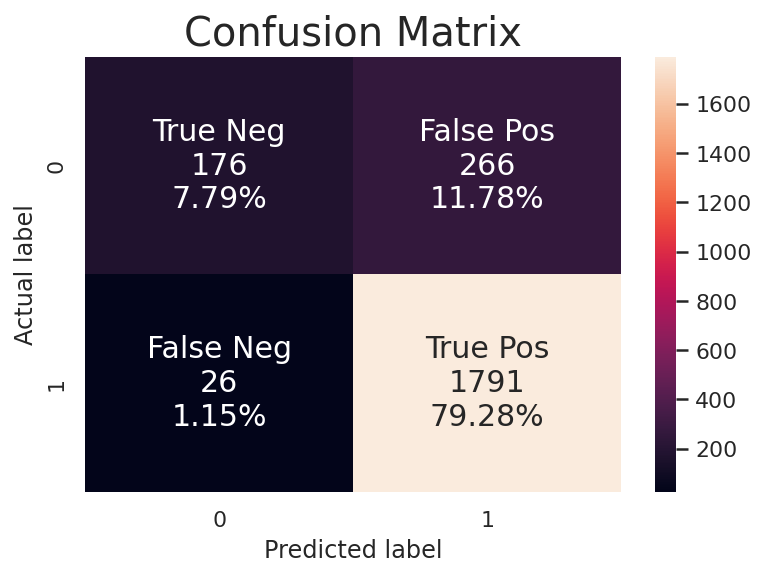

In [100]:
logReg_cv = LogisticRegression(max_iter=1000, C = 0.02).fit(train_cv, y_train)
evaluation(logReg_cv, train_cv, test_cv)

- A logistic regression is trained with 80% of the tweet data. The model shows **87% accuracy** when applied on the test set

In [101]:
y_pred = logReg_cv.predict(test_cv)
logReg_cv_acc = accuracy_score( y_test, y_pred)
logReg_cv_f1_score = f1_score(y_test, y_pred, average='weighted')


#### **Understanding the Confusion Matrix**

- **True positives (TP)** : The model predicted that tweet is **negative** sentiment  and the tweet is actually **negative** sentiment.
- **False positives (FP)** :The model predicted that tweet is **negative** sentiment and the tweet is actually **positive** sentiment.
- **True negatives (TN)** : The model predicted that tweet is **positive** sentiment and the tweet is actually **positive** sentiment.
- **False negatives (FN)** : The model predicted that tweet is **positive** sentiment and the tweet is actually **negative** sentiment.


In this project, a **False Positive** would mean that the model predicted a tweet to be negative, but it was actually positive.The down side to this is that a bot would respond to a customer that had a positive experience and offer a discount or refund and cause a customer service representative to reach out when there isn’t a reason to. This will cause the company to lose money and waste time.

 A **False Negative** would mean that the model predicted a positive sentiment tweet, but it was actually a negative sentiment tweet. 
The down side to this is that the customer will not receive the proper customer service help and may never fly with a particular airline again. This will ultimately cause the airline company to lose money.

In this scenario, since both low recall and low precision have significant downsides, we could use the F1-score. We want to find as much as possible of the negative sentiment tweets. We also don't need bots and customer service representatives wasting time and money on responding to customers and offering discounts if the tweet is a positive sentiment. 
<!-- 
This metric might change based on an individual airline’s particular situation in which either finding more of the customers with negative sentiment or saving more money would take on more importance. The default threshold and the optimized F1-score have similar metrics. We would need a cost analysis of the false positives and compare them to the false negatives to determine the next best step for the airline. -->

### Naive Bayes

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.93
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


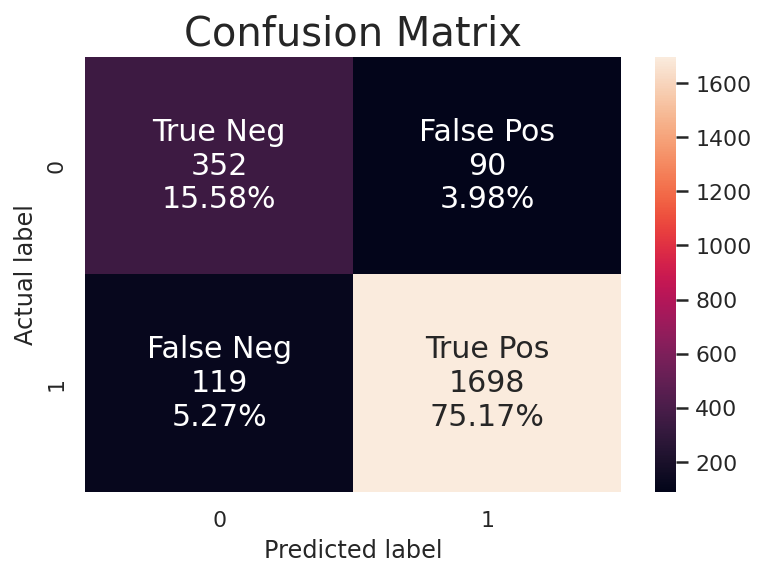

In [102]:
bnb_cv= BernoulliNB().fit(train_cv, y_train)
evaluation(bnb_cv ,train_cv, test_cv)

- The accuracy score on the training data is higher than the accuracy score on the test data (0.93 vs 0.91). This could indicate that the model is overfitting to the training data, and performing worse on new, unseen data

In [103]:
y_pred = bnb_cv.predict(test_cv)
bnb_cv_acc = accuracy_score( y_test, y_pred)
bnb_cv_f1_score = f1_score(y_test, y_pred, average='weighted')

### Support Vector Classifier 

Accuracy score is: 0.91
The F1 score is: 0.90

The recall score is: 0.98
The precision score is: 0.91 


Accuracy on training data: 0.96
Accuracy on test data:     0.91


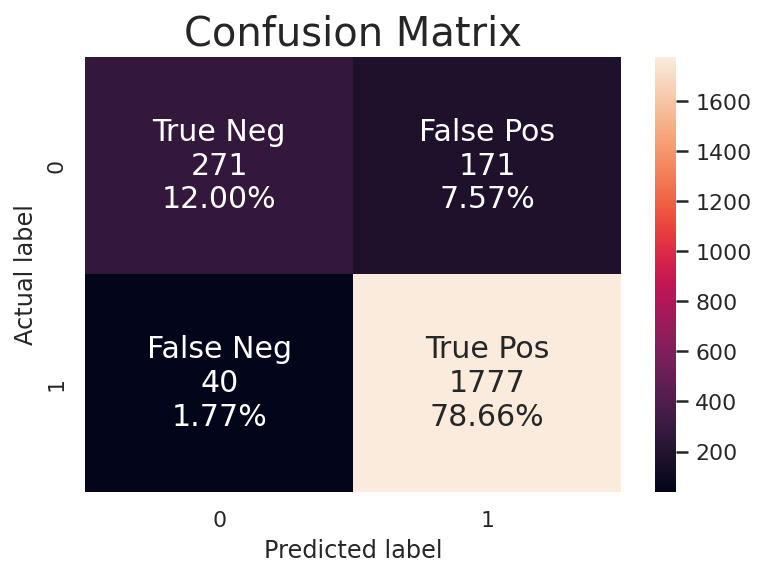

In [104]:
svc_cv = svm.SVC().fit(train_cv, y_train)
evaluation(svc_cv ,train_cv, test_cv)

- The precision score of 0.91 suggests that the model is doing a good job at avoiding false negatives. This is often more important in applications where false negatives can lead to serious consequences. In our case, both low recall and low precision have significant downsides.
- It's also worth noting that the accuracy on the training data is significantly higher than the accuracy on the test data (0.96 vs 0.91).It indicates that the overfitting issue has worsened in this model.

In [110]:
y_pred = svc_cv.predict(test_cv)
svc_cv_acc = accuracy_score( y_test, y_pred)
svc_cv_f1_score = f1_score(y_test, y_pred, average='weighted')

## TF-IDF

In [112]:
X = df['text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(9036,)
(2259,)


In [113]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.70)
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)


print(train_tfidf.shape , y_train.shape)
print(test_tfidf.shape , y_test.shape)

(9036, 1925) (9036,)
(2259, 1925) (2259,)


### Logistic Regression

Accuracy score is: 0.82
The F1 score is: 0.74

The recall score is: 1.00
The precision score is: 0.81 


Accuracy on training data: 0.81
Accuracy on test data:     0.82


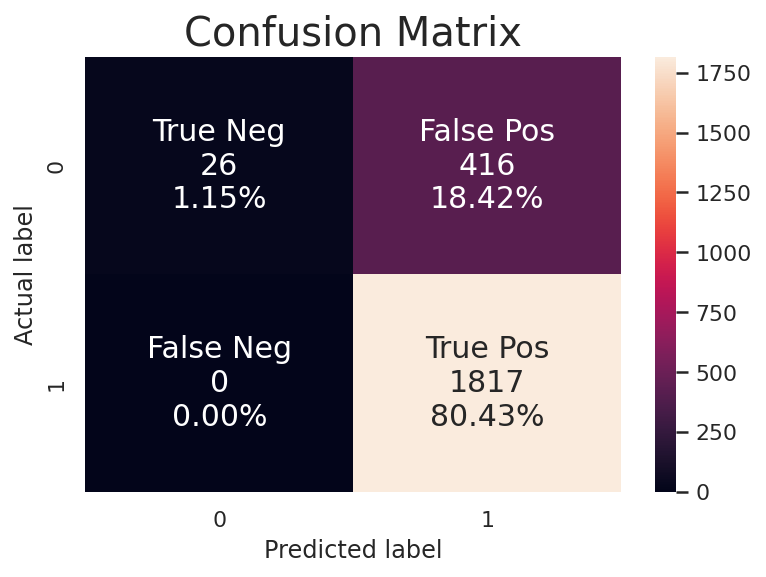

In [114]:
logReg_tfidf = LogisticRegression(max_iter=1000, C = 0.02).fit(train_tfidf, y_train)
evaluation(logReg_tfidf ,train_tfidf, test_tfidf)

- The accuracy score of 0.82 indicates that the model is able to correctly predict the outcome 82% of the time. The F1 score of 0.74 shows a balance between precision (0.81) and recall (1.00).A recall score of 1.00 means the model is able to identify all actual positive cases, while a precision score of 0.81 means that 81% of the positive predictions made by the model are true.

- The model appears to have a slightly better performance on the test data (0.82) compared to the training data (0.81). This suggests that the model may not be overfitting the training data and has a good generalization capability.

In [115]:
y_pred = logReg_tfidf.predict(test_tfidf)
logReg_tfidf_acc = accuracy_score( y_test, y_pred)
logReg_tfidf_f1_score = f1_score(y_test, y_pred, average='weighted')

### Naive Bayes

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.93
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


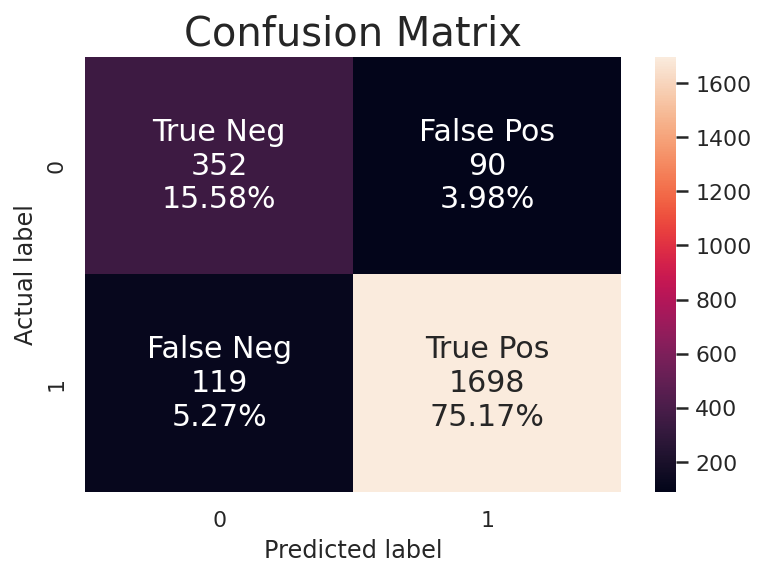

In [116]:
bnb_tfidf = BernoulliNB().fit(train_tfidf, y_train)
evaluation(bnb_tfidf ,train_tfidf, test_tfidf)

- The accuracy on the training data is higher than the accuracy on the test data (0.93 vs 0.91). This could indicate that the model is overfitting to the training data
- The F1 score of 0.91 suggests that the model is balancing precision and recall well, which is good.

In [117]:
y_pred = bnb_tfidf.predict(test_tfidf)
bnb_tfidf_acc = accuracy_score( y_test, y_pred)
bnb_tfidf_f1_score = f1_score(y_test, y_pred, average='weighted')

### Support Vector Classifier

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.98
The precision score is: 0.92 


Accuracy on training data: 0.98
Accuracy on test data:     0.91


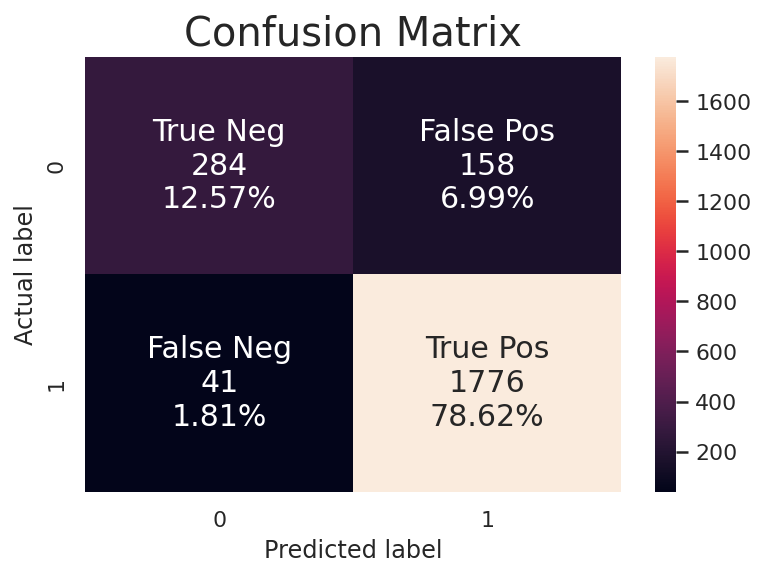

In [118]:
svc_tfidf = svm.SVC().fit(train_tfidf, y_train)
evaluation(svc_tfidf ,train_tfidf, test_tfidf)

- The accuracy on the training data is significantly higher than the accuracy on the test data (0.98 vs 0.91). It indicates that the overfitting issue has worsened compared to previous models.

- **SVC_tfidf** (Support Vector Classifier)    model is slightly higher accuracy and F1 score compared to **Naive Bayes** model.





In [119]:
y_pred = svc_tfidf.predict(test_tfidf)
svc_tfidf_acc = accuracy_score( y_test, y_pred)
svc_tfidf_f1_score = f1_score(y_test, y_pred, average='weighted')

#### Lets Improve the Model

In [ ]:
# tfidf = TfidfVectorizer(min_df=5, max_df=0.70)
# train_tfidf = tfidf.fit_transform(X_train)
# test_tfidf = tfidf.transform(X_test)


# print(train_tfidf.shape , y_train.shape)
# print(test_tfidf.shape , y_test.shape)

 **Tuning SVC**

In order to improve the model accuracy, there are several parameters need to be tuned. Three major parameters including:

- **Kernels:** The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. It is mostly useful in non-linear separation problem.

- **C (Regularisation):** C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimisation how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term.when C is high it will classify all the data points correctly, also there is a chance to overfit.

- **Gamma:** It defines how far influences the calculation of plausible line of separation.when gamma is higher, nearby points will have high influence; low gamma means far away points also be considered to get the decision boundary.



In [121]:
## 8 mins
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']
              }

svc_gs = GridSearchCV(SVC(),
                      param_grid,
                      cv=5,
                      n_jobs = -1, # Setting n_jobs=-1 means to use all the CPU cores instead of just 1 (the default) 
                                   #This allows us to speed up the computation by performing tasks in parallel 
                      )

svc_gs.fit(train_tfidf,y_train)

print(svc_gs.best_params_)
print(svc_gs.best_score_)



{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.9123494057034834


Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.97
The precision score is: 0.93 


Accuracy on training data: 0.94
Accuracy on test data:     0.91


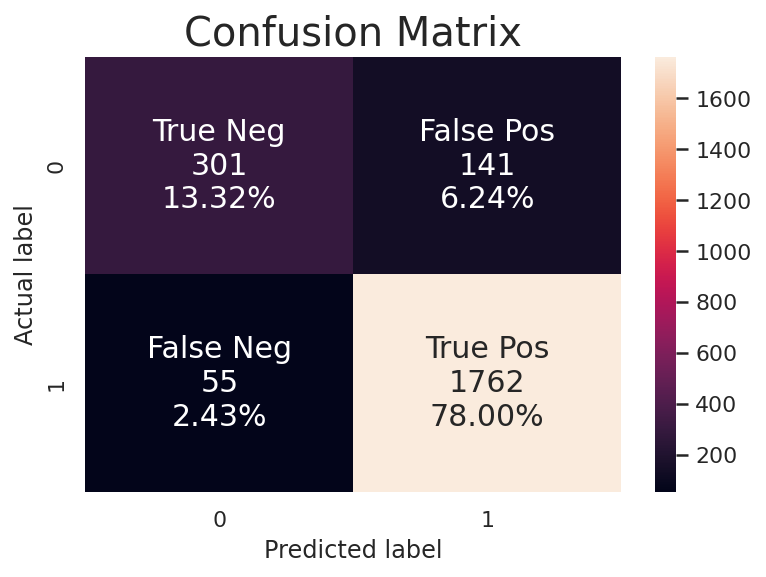

In [123]:
svc_tuned = SVC(C= 10, gamma= 0.1, kernel= 'sigmoid',probability=True).fit(train_tfidf, y_train)
evaluation(svc_tuned ,train_tfidf, test_tfidf)


Tuning the parameters of a Support Vector Classifier (SVC) algorithm helped reduce overfitting.



In [124]:
y_pred = svc_tuned.predict(test_tfidf)
svc_tuned_acc = accuracy_score( y_test, y_pred)
svc_tuned_f1_score = f1_score(y_test, y_pred, average='weighted')

**Tuning Naive Bayes**

In [126]:
#We will perform a grid search on the alpha values
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
         }

#Using grid search
bnb_gs = GridSearchCV(BernoulliNB(),
                      param_grid=params,
                      n_jobs=-1,
                      cv=5)

#Fit on train data
bnb_gs.fit(train_tfidf, y_train)

print(bnb_gs.best_params_)
print(bnb_gs.best_score_)


{'alpha': 0.5}
0.9033855556807108


Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.94
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


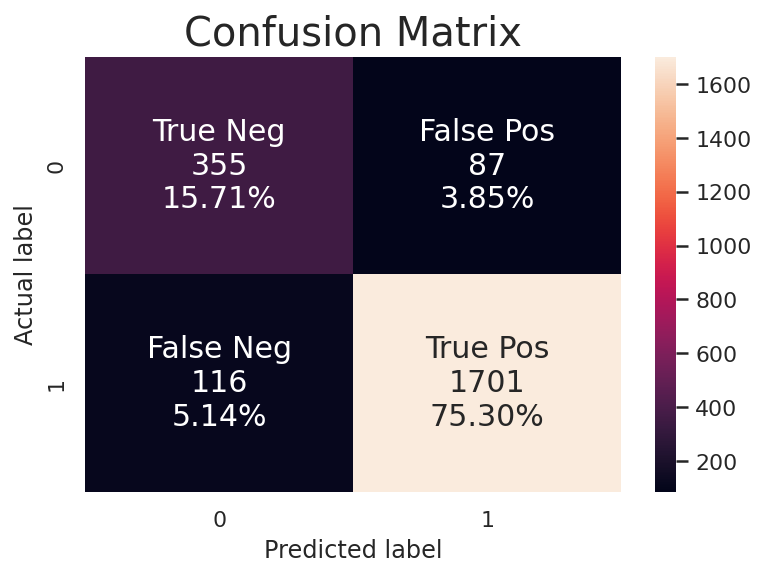

In [127]:
bnb_tuned = BernoulliNB(alpha= 0.5).fit(train_tfidf, y_train)
evaluation(bnb_tuned ,train_tfidf, test_tfidf)

- Tuning Naive Bayes didnt make any difference.

In [129]:
y_pred = bnb_tuned.predict(test_tfidf)
bnb_tuned_acc = accuracy_score( y_test, y_pred)
bnb_tuned_f1_score = f1_score(y_test, y_pred, average='weighted')

### Long Short Term Memory Networks(LSTM)

In [130]:
#Specifing our target variable
df2 = df[['airline_sentiment' , 'text']]
X = df2['text']
y = df2['airline_sentiment']

In [131]:
#Encoding the target variable
y_d = pd.get_dummies(y).values

In [132]:
#Tokenizing our data, converting to sequence and padding to the same length
tokenizer =Tokenizer(num_words=5000) # lower=True, split=' '
tokenizer.fit_on_texts(df2['text'])
list_tokenized_headlines = tokenizer.texts_to_sequences(df2['text'])
X_t = pad_sequences(list_tokenized_headlines, maxlen=100 , padding='post') #padding='post'

print('Before Tokenization & Padding \n', df2['text'][3],'\n')
print('After Tokenization & Padding \n', X_t[3])

Before Tokenization & Padding 
 seriously would pay flight seat didnt playing really bad thing flying va 

After Tokenization & Padding 
 [ 263   29  171    1   36   98 1782   52  115  184   71 1512    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [133]:
#Splitting our data with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X_t, y_d, test_size=0.2, random_state=42, stratify=y)

print('Train:'            ,X_train.shape, y_train.shape)
print('Test Set:'         ,X_test.shape, y_test.shape)

Train: (9036, 100) (9036, 2)
Test Set: (2259, 100) (2259, 2)


In [134]:
vocab_size = 5000
embedding_size = 32
epochs=50
max_words = 5000
max_len = 100
batch_size = 64

#Insantiate the model
model= Sequential()

# embed our model of size 32, to an embedding space of 5000
# which reps the total vocabulary we want
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))

# add another layer with an activation function of 'relu' Rectified Linear Activation
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

# Feed the data into an LSTM(Long Short Term Memory) with 32 nodes
model.add(Bidirectional(LSTM(32)))

# add a dropout layer to reduce overfitting
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [135]:
#Model compilation
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [136]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [137]:
#Trying early stopping to prevent overfitting
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64
  
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1, callbacks = es)

Epoch 1/50
113/113 [==============================] - 14s 87ms/step - loss: 0.4652 - accuracy: 0.8049 - val_loss: 0.3207 - val_accuracy: 0.8634
Epoch 2/50
113/113 [==============================] - 9s 76ms/step - loss: 0.2098 - accuracy: 0.9214 - val_loss: 0.2470 - val_accuracy: 0.9093
Epoch 3/50
113/113 [==============================] - 7s 65ms/step - loss: 0.1212 - accuracy: 0.9553 - val_loss: 0.2364 - val_accuracy: 0.9104
Epoch 4/50
113/113 [==============================] - 9s 79ms/step - loss: 0.0827 - accuracy: 0.9727 - val_loss: 0.2797 - val_accuracy: 0.9082
Epoch 5/50
113/113 [==============================] - 9s 83ms/step - loss: 0.0557 - accuracy: 0.9828 - val_loss: 0.3268 - val_accuracy: 0.9071
Epoch 6/50
113/113 [==============================] - 11s 102ms/step - loss: 0.0401 - accuracy: 0.9864 - val_loss: 0.3646 - val_accuracy: 0.9104
Epoch 7/50
113/113 [==============================] - 9s 80ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.4095 - val_accuracy: 0.9

In [138]:
#Evaluate the model
loss, accuracy = model.evaluate(X_test,y_test ,  verbose=0)
print('Accuracy  : {:.2f}'.format(accuracy))

Accuracy  : 0.91


- The log shows that the training loss decreases and accuracy increases as the number of epochs increases. However, the validation loss and accuracy values tend to increase slightly after a few epochs. This suggests that the network is starting to overfit to the training data. 

<!-- To address this issue, regularization techniques, such as dropout, could be applied to the network, or the training process could be stopped earlier. -->

71/71 [==============================] - 2s 16ms/step


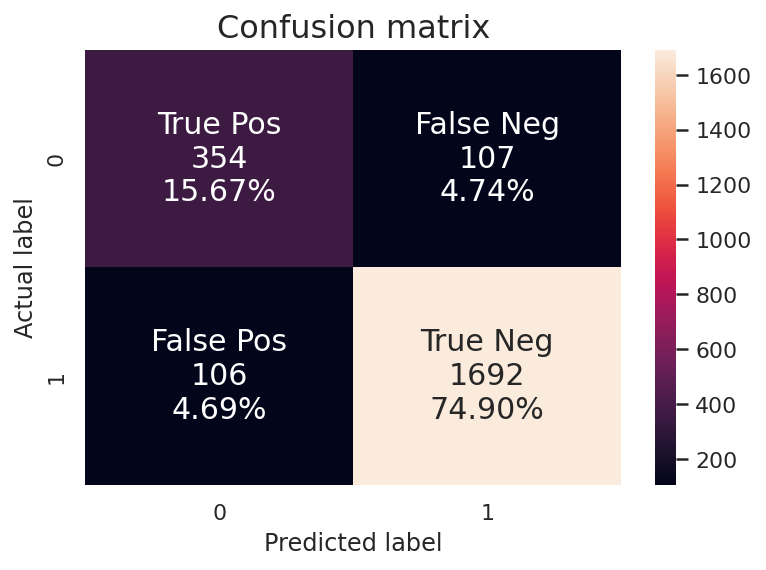

In [139]:
def plot_confusion_matrix(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

#Visualize Confusion Matrix
    groupNames = ["True Pos", "False Neg", "False Pos", "True Neg"]
    groupCount = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
    groupPercent = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
                     
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(groupNames,groupCount,groupPercent)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='rocket', annot_kws={"fontsize":15})
    plt.title("Confusion Matrix", fontsize=16)

    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
  
plot_confusion_matrix(model, X_test, y_test)
    

#### Compare Scoring

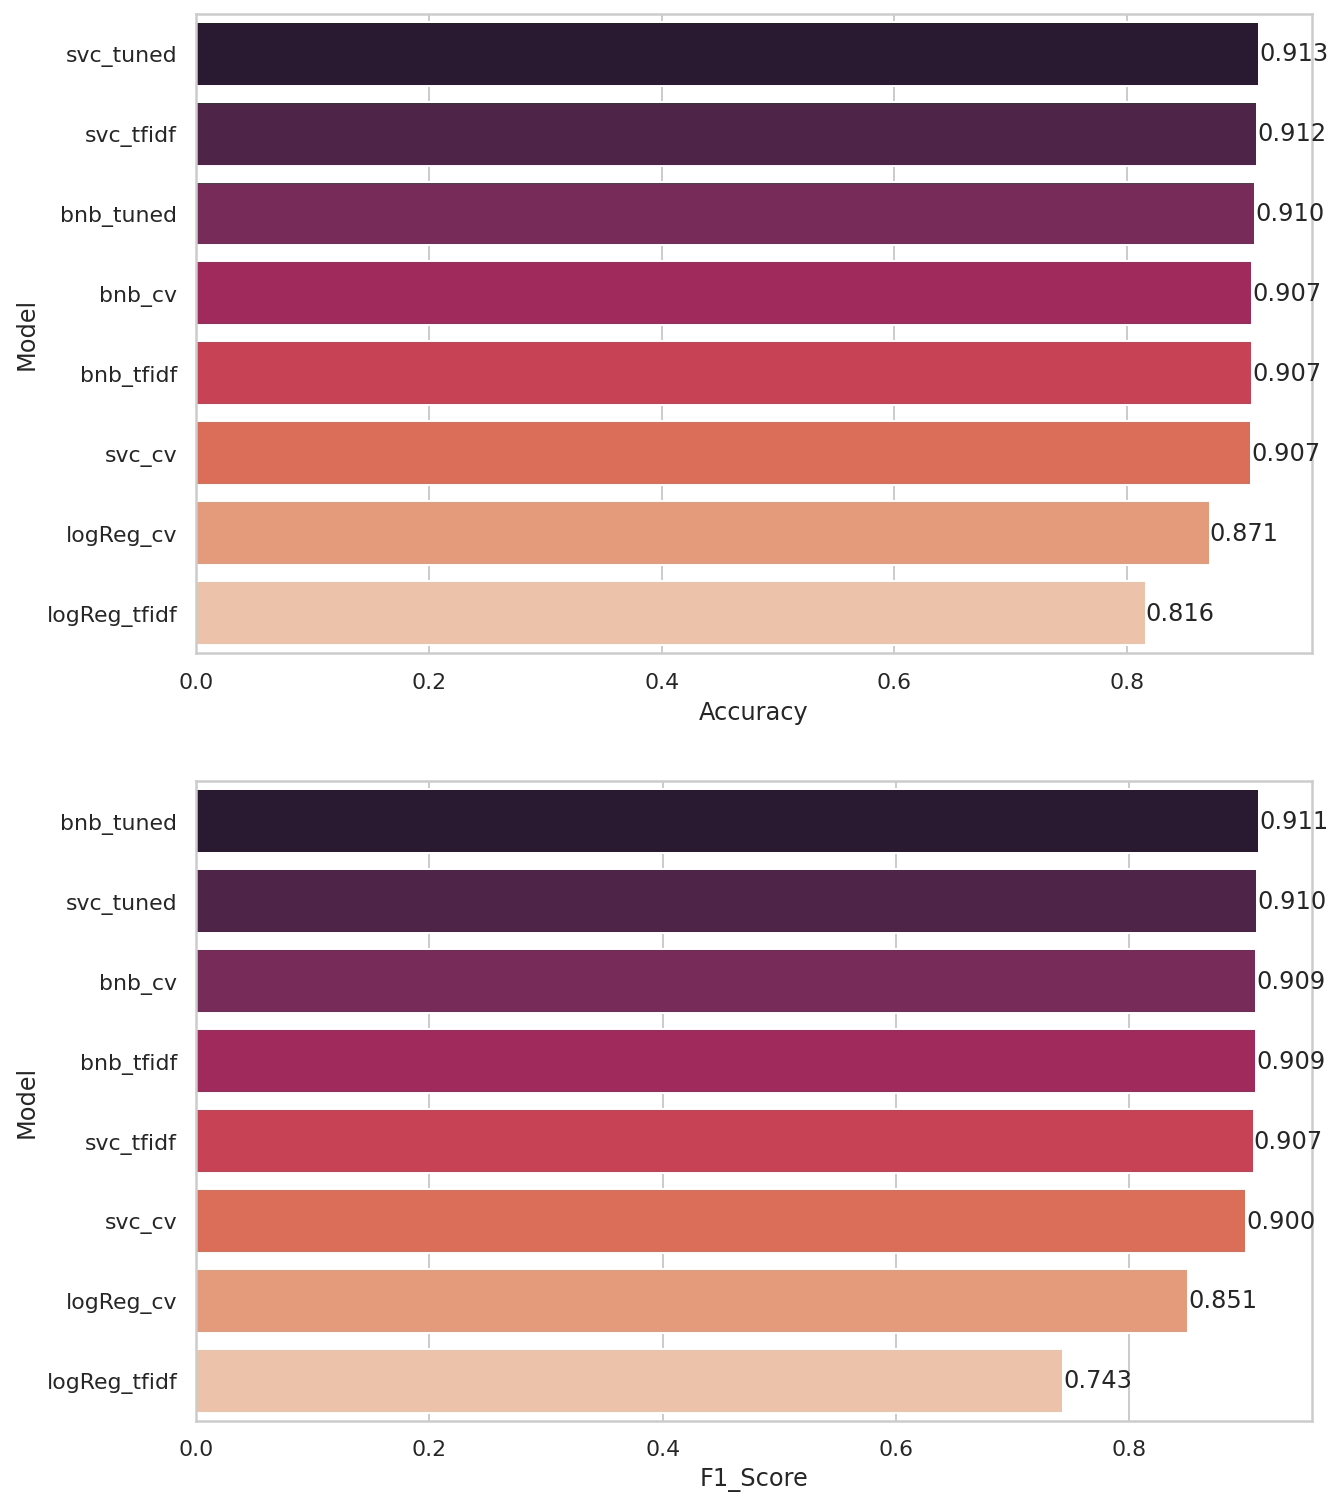

In [140]:
compare = pd.DataFrame({"Model": ["logReg_cv", "bnb_cv", "svc_cv",
                                  "logReg_tfidf", "bnb_tfidf", "svc_tfidf", 
                                  "svc_tuned", "bnb_tuned"],
                        
                        "F1_Score": [logReg_cv_f1_score, bnb_cv_f1_score, svc_cv_f1_score,
                                     logReg_tfidf_f1_score , bnb_tfidf_f1_score, svc_tfidf_f1_score,
                                     svc_tuned_f1_score, bnb_tuned_f1_score],
                        
                        "Accuracy": [logReg_cv_acc, bnb_cv_acc, svc_cv_acc,
                                     logReg_tfidf_acc , bnb_tfidf_acc, svc_tfidf_acc,
                                     svc_tuned_acc, bnb_tuned_acc]})
                        

def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(10,20))
plt.subplot(311)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="rocket")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="F1_Score", ascending=False)
ax=sns.barplot(x="F1_Score", y="Model", data=compare, palette="rocket")
labels(ax)

plt.show();

**Best accuracy and F1 score were achieved through parameter tuning with GridSearch on Support Vector Classifier**



#### Prediction For New Tweets with Pipeline

In [141]:
pipe = Pipeline([('tfidf',TfidfVectorizer(min_df=5, max_df=0.70)),('svc',SVC(C= 100, gamma= 0.01, kernel= 'sigmoid'))])

In [142]:
pipe.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.7, min_df=5)),
                ('svc', SVC(C=100, gamma=0.01, kernel='sigmoid'))])

In [143]:
tweet = "you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

[1]


In [144]:
tweet = "booked flights for 2 for $779. Was charged $389.50 twice. Means I can't redeem CC points properly. Would have gone elsewhere.	"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

[1]


In [145]:
tweet = " I'm rebooked now, but the line was 300 people deep.	"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

[1]


In [146]:
tweet = " Please than Robin at EWR Premiere Desk for helping me get on a an earlier flight. She did the work.Huge thanks."
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

[0]


In [147]:
#predicted as negative ??
tweet = "counter agents at RDU deserve a medal.	"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))


[1]


In [148]:
tweet = "counter agents at RDU deserve a medal. #thankyou"	
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))



[0]


In [149]:
tweet = "@united flight 3763 IAd-Sat. We're on the outdoor track for an hour	"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

	

[1]


In [150]:
tweet = "@united Okay thanks if you could please update me. I was told at the airport someone would call me today but they haven't.	"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

[1]


In [151]:
tweet = "@united fails again. @SouthwestAir saves the day."
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))


[1]


In [152]:
#labeled as negative but model predicted as positive 
tweet = "@united that's cool - now what?"
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))



[0]


In [153]:
# labeled as neutral tweet but model predicted as negative
tweet = "@united @retailbagholder hahaha. At least they gave u a refund."
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))


[1]


- The model appears to be working effectively and consistently making accurate predictions for sentiment classification in general
- But still there is some point we need to consider: Interpreting sentiment in text can be complex, as the tone and intent of a message can be influenced by various factors such as sarcasm and irony



# Conclusion

- Firstly  I made use of TfidfVectorizer and CountVectorizer to transfer Tweet contents into vectors, in order to train the model in the proper form and shape.Then I fed the vectorized tweets into ScikitLearn's Logistic Regression , Bernoulli Naive Bayes and  Support Vector Classifiers and additionly to that I tested data using Long Short Term Memory Networks(LSTM) which is a deep learning model.

- Next step was fine-tuning the parameters of the
best model in an attempt to increase the accuracy rate by using GridSearch.

- The highest accuracy rate yielded by Support Vector Classifier using tfidf.
The model had an accuracy score of 92% on test data which means the model will predict 92 out of 100 true positive or true negative. 8 out of 100 tweets is going to be false for true positive or negatives.

- And the model had an f1 score of 91%, which indicating that high level of accuracy in terms of both precision and recall. This score suggests that the model is performing well in terms of correctly identifying positive cases while also minimizing FPs and FNs errors.

# Recommendation

-  One thing I noticed is that a tweet can have positive language, but the user can be using sarcasm which can throw the model off. With more time, we should look deeper into this.
- The bot might offer personalized solutions based on the negative sentiment reason. For example, if a customer is dissatisfied with flight delays, we might offer alternatives such as offering a discount or refund.

# Next Steps

- Further investigation into the causes of misclassification could be the next step to enhance the model. 
- The data was limited to tweets from February 2015, it is probable that collecting data for the entire year would result in a more robust and generalizable model
- According to the analysis the data set contains way more negative tweets than positive ones. Future works may focus on obtaining a more balanced and larger dataset for better classifier model performance
